In [1]:
using Pkg
Pkg.add(["Combinatorics", "Plots"])

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/PycharmProjects/machine_learning/Project.toml`
  No Changes to `~/PycharmProjects/machine_learning/Manifest.toml`


In [2]:
using Combinatorics
using LinearAlgebra
using Plots

In [3]:
function polynomial_features(X, degree)

    n_samples, n_features = size(X)

    combs = [with_replacement_combinations(1:n_features, i) for i in 0:degree+1]

    combinations = []
    for sublist in combs
        for j in sublist
             push!(combinations, j)
        end
    end
    n_output_features = length(combinations)
    X_new = zeros(n_samples, n_output_features)

    for (i, index_combs) in enumerate(combinations)
        X_new[:, i] = prod(X[:, index_combs], dims=2)
    end

    return X_new

end

polynomial_features (generic function with 1 method)

# Regression polynomial non locale

In [4]:
f(x, y) = - sin(x) .+ 0.5 * cos(y) 
n, p = 1000, 2
degree = 3
X = randn(n, p)
Y_true = f.(X[:,1],X[:,2]) 
Y = Y_true .+ 0.2 .* randn(n)
X_new = polynomial_features(X, degree)
beta = X_new \ Y

X_grid = hcat(vcat([0.1i for i in -20:20, j in -20:20]...),
              vcat([0.1j for i in -20:20, j in -20:20]...))
Y_true = f.(X_grid[:,1], X_grid[:,2])
X_grid_new = polynomial_features( X_grid, degree)
Y_grid = X_grid_new * beta
plot(X_grid[:,1], X_grid[:,2], Y_grid, st=:surface, alpha=0.5 )
scatter!(X[:,1], X[:,2], Y, ms = 1)

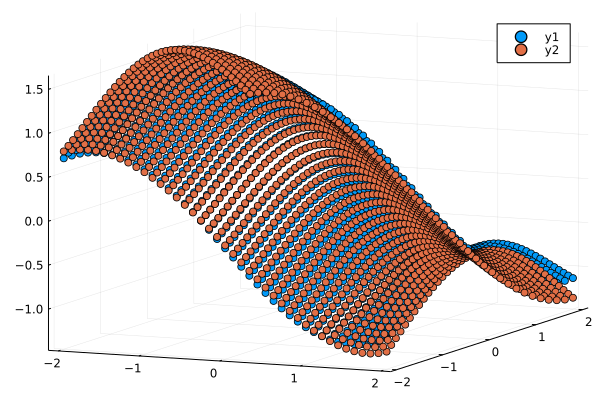

In [5]:

scatter( X_grid[:,1], X_grid[:,2], Y_true)
scatter!(X_grid[:,1], X_grid[:,2], Y_grid)

In [6]:
abstract type AbstractKernel end

struct Epanechnikov <: AbstractKernel end

"""
    epanechnikov(t)

Compute the Epanechnikov kernel.
"""
function (::Epanechnikov)(t)

    kernel = zero(t)
    idx = findall(abs.(t) .<= 1)
    kernel[idx] = 0.75 .* (1 .- t[idx].^2)
    return kernel

end



Epanechnikov

# Regression locale 

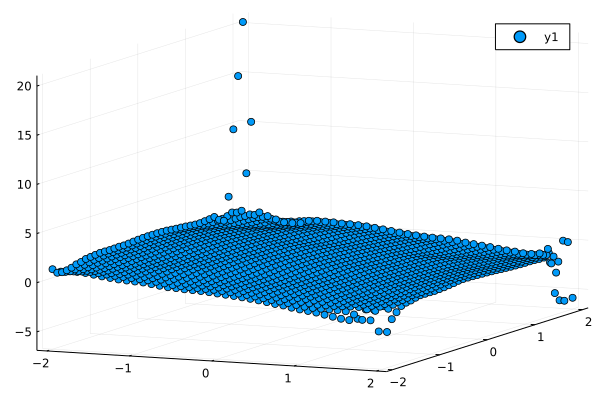

In [7]:
kernel = Epanechnikov()
width = 1

Y_pred = Float64[]
for x in eachrow(X_grid)
    dist = sqrt.(sum((X .- x').^2, dims=2)) ./ width
    w = vec(kernel(dist))
    idx = findall(abs.(w) .> 1e-10)
    beta = pinv(X_new[idx,:]' * Diagonal(w[idx]) * X_new[idx,:]) * (X_new[idx,:]' * Diagonal(w[idx]) * Y[idx])
    P = polynomial_features(x', degree)
    
    push!(Y_pred, P * beta...)
end

scatter( X_grid[:,1], X_grid[:,2], Y_pred)